In [9]:
# These are all the modules we'll be using later. Make sure you can import them
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
# First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.
from PIL import Image
# In[ ]:

url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename


train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)


Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


In [2]:
num_classes = 10
np.random.seed(133)


def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [
        os.path.join(root, d) for d in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, d))]
    if len(data_folders) != num_classes:
        raise Exception(
            'Expected %d folders, one per class. Found %d instead.' % (
                num_classes, len(data_folders)))
    print(data_folders)
    return data_folders


train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)


notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


In [3]:
from IPython.display import Image
Image(filename='notMNIST_small/E/SWFkZWxvbi1EZW1pQm9sZC5vdGY=.png')

In [4]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large\A.pickle.
notMNIST_large\A
Could not read: notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large\B.pickle.
notMNIST_large\B
Could not read: notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_lar

(52911, 28, 28)


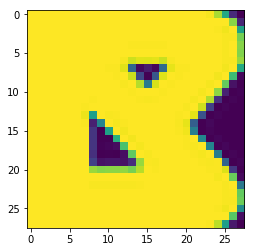

In [20]:
%matplotlib inline

import scipy.misc

data_b = pickle.load(open( './notMNIST_large/B.pickle', "rb" ))
print(data_b.shape)
plt.imshow(data_b[1023])

array([0, 0, 0, ..., 9, 9, 9])

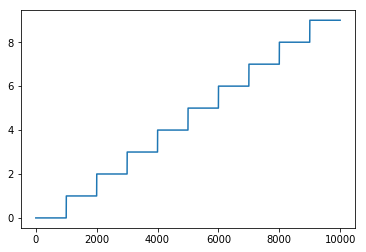

In [21]:
display(test_labels)
plt.plot(test_labels);

display(test_labels[0])
plt.imshow(test_dataset[0]);



In [17]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [7]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

0

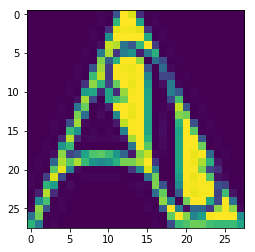

In [22]:
display(test_labels[0])
plt.imshow(test_dataset[0]);

In [23]:
labels_probs = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
for label in test_labels:
    labels_probs[label] += 1
display(labels_probs)

{0: 1000,
 1: 1000,
 2: 1000,
 3: 1000,
 4: 1000,
 5: 1000,
 6: 1000,
 7: 1000,
 8: 1000,
 9: 1000}

In [10]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [11]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


In [26]:
import time

def check_overlaps(images1, images2):
    start = time.clock()
    hash1 = set([hash(image1.tobytes()) for image1 in images1])
    hash2 = set([hash(image2.tobytes()) for image2 in images2])
    all_overlaps = set.intersection(hash1, hash2)
    return all_overlaps, time.clock()-start

r, execTime = check_overlaps(train_dataset, test_dataset)    
print('Number of overlaps between training and test sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(train_dataset, valid_dataset)   
print('Number of overlaps between training and validation sets: {}. Execution time: {}.'.format(len(r), execTime))

r, execTime = check_overlaps(valid_dataset, test_dataset) 
print('Number of overlaps between validation and test sets: {}. Execution time: {}.'.format(len(r), execTime))

Number of overlaps between training and test sets: 1181. Execution time: 1.2052940782646573.
Number of overlaps between training and validation sets: 941. Execution time: 1.0575486225019262.
Number of overlaps between validation and test sets: 64. Execution time: 0.11176681284102585.


In [15]:
from IPython.core.display import display
def train(n):
    dataset = valid_dataset[:n]
    labels = valid_labels[:n]

    clf = LogisticRegression()
    clf.fit([data.flatten() for data in dataset], labels)
    return clf.coef_

display(train(50))
display(train(100))
display(train(1000))
display(train(5000))

array([[ 0.01987224, -0.09124394, -0.0603062 , ...,  0.14476234,
         0.14606756,  0.18519921],
       [ 0.15122477,  0.05182917,  0.0031575 , ..., -0.12944091,
        -0.16468075,  0.01686162],
       [ 0.00477056, -0.04066089, -0.04671649, ...,  0.07524581,
         0.06063478,  0.09601176],
       ..., 
       [ 0.07781169,  0.10110704,  0.0805329 , ...,  0.09741471,
         0.12768132,  0.09412896],
       [ 0.03704459,  0.01613577,  0.02114712, ...,  0.07924584,
         0.0675938 ,  0.09663016],
       [ 0.06037766, -0.05516275, -0.09157431, ..., -0.02827056,
        -0.01730419,  0.08896377]])

array([[ 0.04147324, -0.06954571, -0.03997449, ...,  0.19901017,
         0.17736448,  0.23028617],
       [ 0.17977087,  0.07157204,  0.0356704 , ..., -0.0587723 ,
        -0.13440524,  0.00741513],
       [ 0.0582648 ,  0.02538772,  0.03377788, ...,  0.17390931,
         0.12872962,  0.20501714],
       ..., 
       [ 0.05825745,  0.09213982,  0.05525083, ...,  0.12708798,
         0.13044386,  0.1196751 ],
       [ 0.12567367,  0.09582429,  0.09436257, ...,  0.12273221,
         0.10162173,  0.206516  ],
       [ 0.214607  ,  0.07014669,  0.04186458, ...,  0.09745951,
         0.08624273,  0.21933062]])

array([[-0.14110795, -0.39141265, -0.23741161, ...,  0.28176699,
         0.65851191,  0.73856864],
       [ 0.23046249, -0.0871187 , -0.11014394, ..., -0.37563847,
        -0.09365662,  0.28072186],
       [ 0.0539746 , -0.06391487, -0.07606721, ..., -0.0820466 ,
         0.0700819 ,  0.68148143],
       ..., 
       [ 0.25430734,  0.40582263,  0.33965436, ...,  0.47141034,
         0.27725431, -0.00771939],
       [-0.17411636, -0.17569762, -0.0755297 , ..., -0.33241861,
        -0.52584795, -0.20343351],
       [ 0.20264199, -0.34906813, -0.18710724, ..., -0.27215457,
        -0.24340168,  0.24427543]])

array([[ 0.07126793, -1.15194195, -0.32919333, ...,  0.74011733,
         0.68037386,  1.19762666],
       [ 0.62120376, -0.31047578, -0.09935425, ..., -0.32037019,
        -0.15968143,  0.36263663],
       [ 0.08137445,  0.1159839 , -0.20473501, ..., -0.51714036,
        -0.08883079,  0.87914483],
       ..., 
       [ 0.64655764,  0.40575731,  0.70041942, ...,  0.32351365,
         0.52866478,  0.31850123],
       [-0.14794457,  0.62238164,  0.27733911, ...,  0.03037895,
        -0.45945795, -0.1202927 ],
       [-0.16676787, -0.54748541,  0.25414103, ..., -0.1767516 ,
        -1.0457906 , -0.75957244]])